In [ ]:
!nvidia-smi

Sun Nov 24 21:15:10 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.33.01    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   46C    P0    33W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [ ]:
!pip install gdown
!pip install tensorflow-gpu

In [2]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from pandas.plotting import register_matplotlib_converters

%matplotlib inline
%config InlineBackend.figure_format='retina'

register_matplotlib_converters()
sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 22, 10

RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

In [3]:
!gdown --id 10vdMg_RazoIatwrT7azKFX4P02OebU76 --output spx.csv

c:\python310\lib\site-packages\gdown\cli.py:126: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=10vdMg_RazoIatwrT7azKFX4P02OebU76
To: d:\UKM\Research project\oil production forecasting\github\virtual_env\spx.csv

  0%|          | 0.00/152k [00:00<?, ?B/s]
100%|██████████| 152k/152k [00:00<00:00, 25.3MB/s]


In [107]:
df = pd.read_csv('D:/UKM/Research project/oil production forecasting/github/GA-TCN-LSTM\Datasets/F_14.csv',
usecols=['DATEPRD', 'AVG_DOWNHOLE_PRESSURE'], parse_dates=['DATEPRD'], index_col='DATEPRD')
df = df.dropna()

In [97]:
df.head()

,AVG_DOWNHOLE_PRESSURE
DATEPRD,
2010-01-01,3378.643673
2010-01-02,3377.769461
2010-01-03,3408.561097
2010-01-04,3439.266918
2010-01-05,3429.064568


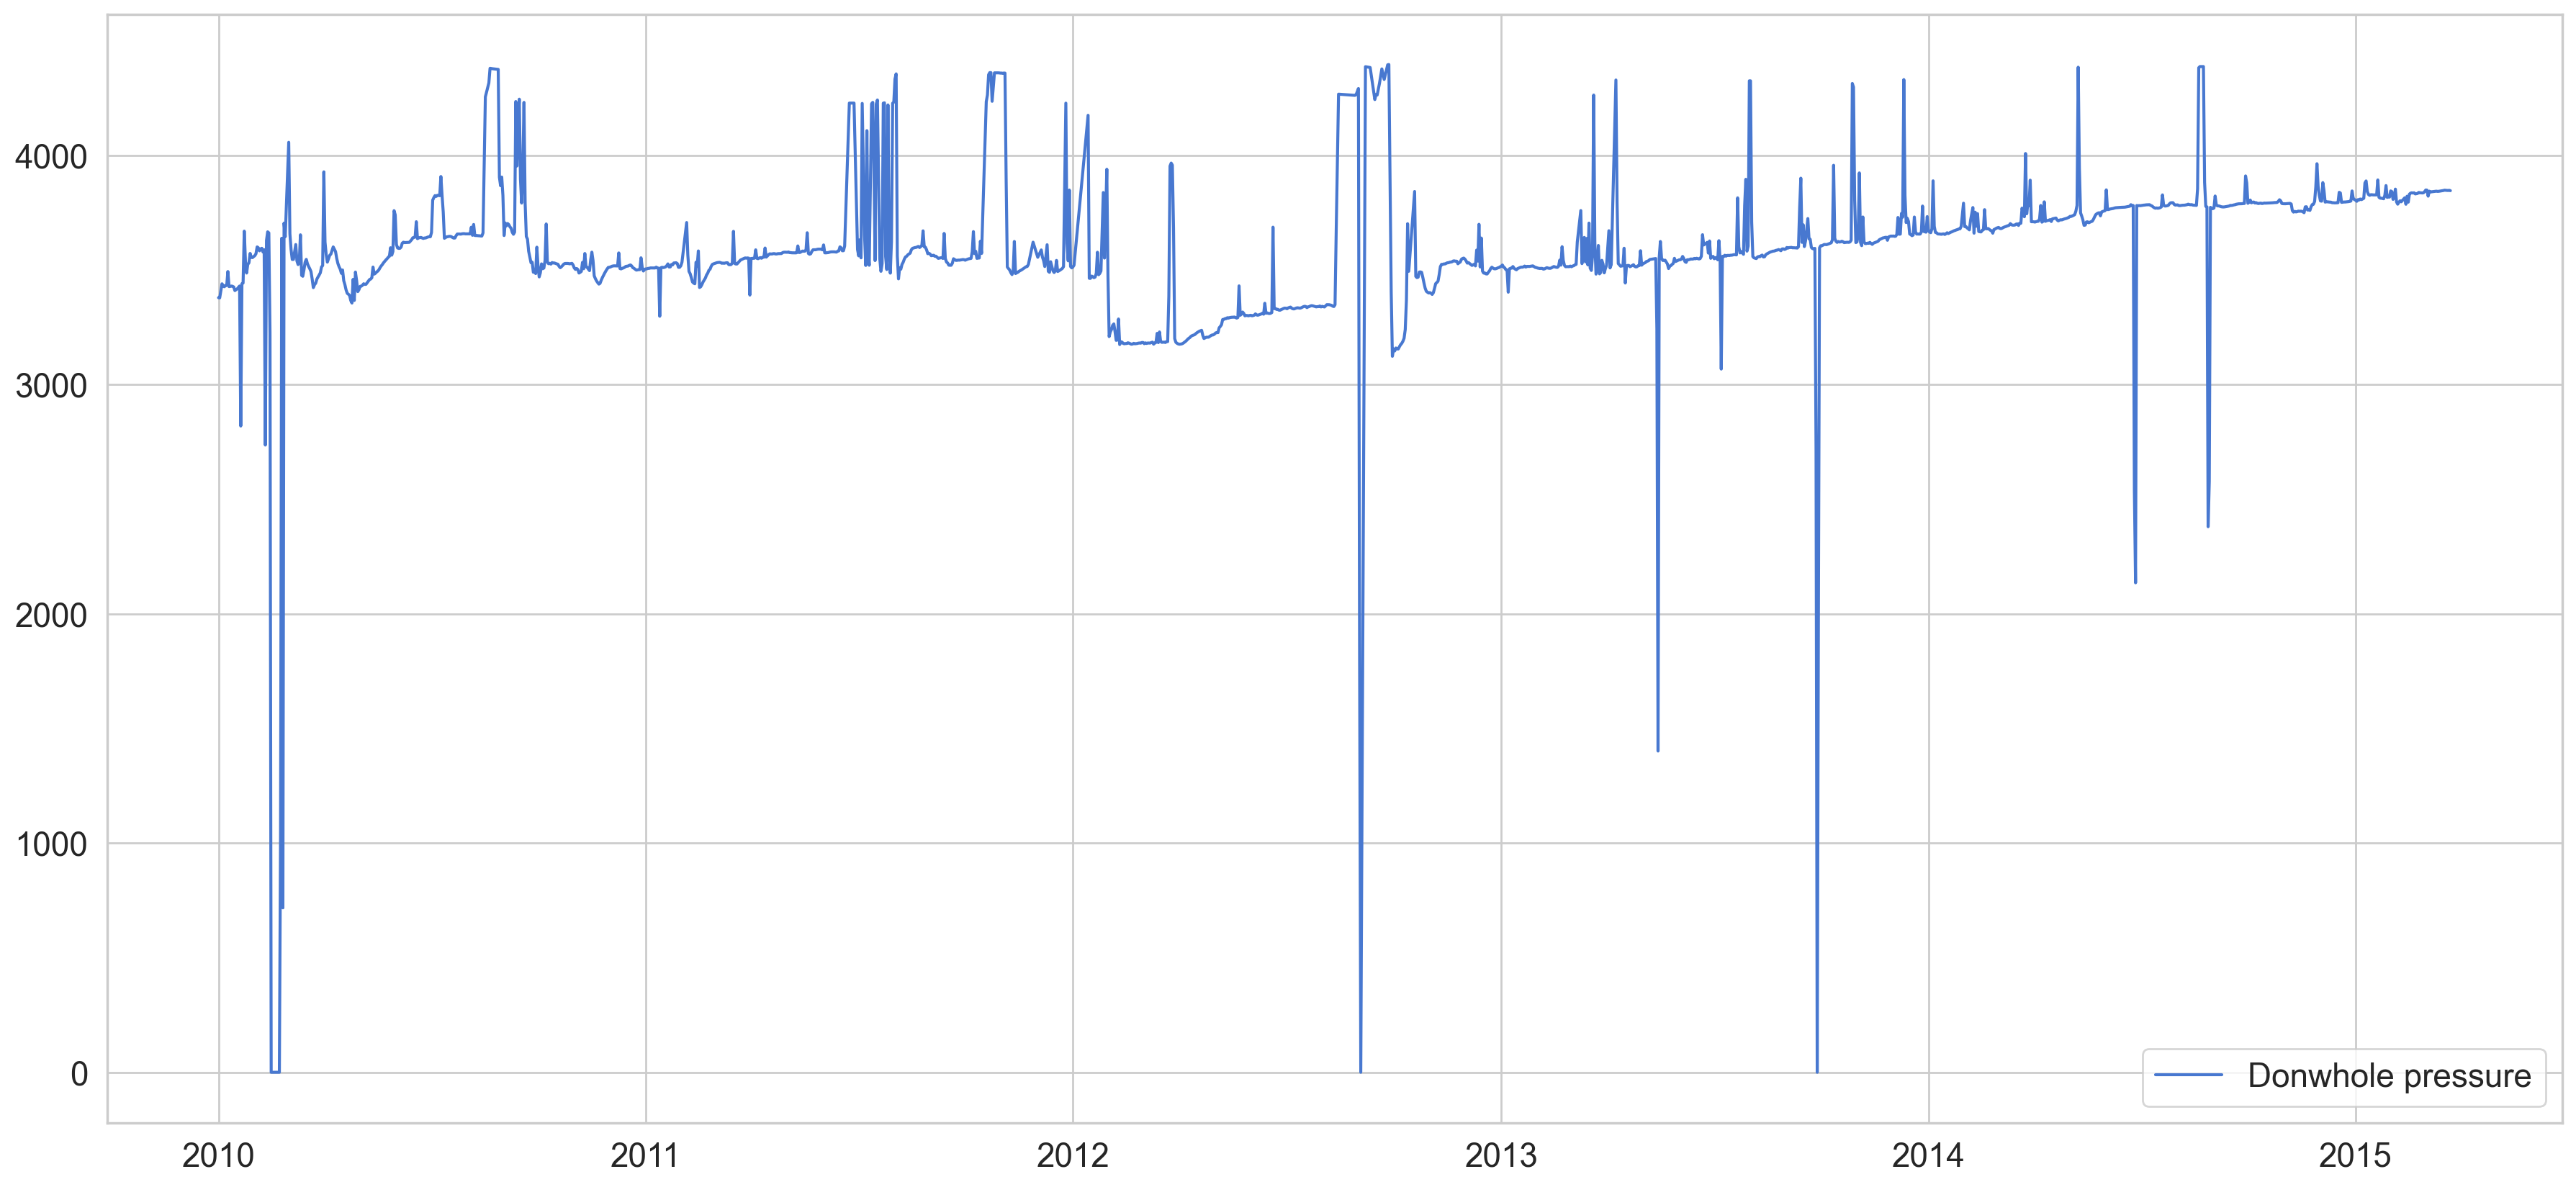

In [108]:
plt.plot(df, label='Donwhole pressure')
plt.legend();

In [109]:
train_size = int(len(df) * 0.95)
test_size = len(df) - train_size
train, test = df.iloc[0:train_size], df.iloc[train_size:len(df)]
print(train.shape, test.shape)

(1736, 1) (92, 1)


In [110]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler = scaler.fit(train[['AVG_DOWNHOLE_PRESSURE']])

train['AVG_DOWNHOLE_PRESSURE'] = scaler.transform(train[['AVG_DOWNHOLE_PRESSURE']])
test['AVG_DOWNHOLE_PRESSURE'] = scaler.transform(test[['AVG_DOWNHOLE_PRESSURE']])

C:\Users\ash\AppData\Local\Temp\ipykernel_5136\2106731294.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['AVG_DOWNHOLE_PRESSURE'] = scaler.transform(train[['AVG_DOWNHOLE_PRESSURE']])
C:\Users\ash\AppData\Local\Temp\ipykernel_5136\2106731294.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['AVG_DOWNHOLE_PRESSURE'] = scaler.transform(test[['AVG_DOWNHOLE_PRESSURE']])


In [103]:
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)        
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

In [111]:
TIME_STEPS = 30

# reshape to [samples, time_steps, n_features]

X_train, y_train = create_dataset(train[['AVG_DOWNHOLE_PRESSURE']], train.AVG_DOWNHOLE_PRESSURE, TIME_STEPS)
X_test, y_test = create_dataset(test[['AVG_DOWNHOLE_PRESSURE']], test.AVG_DOWNHOLE_PRESSURE, TIME_STEPS)

print(X_train.shape)

(1706, 30, 1)


In [112]:
model = keras.Sequential()
model.add(keras.layers.LSTM(
    units=64, 
    input_shape=(X_train.shape[1], X_train.shape[2])
))
model.add(keras.layers.Dropout(rate=0.2))
model.add(keras.layers.RepeatVector(n=X_train.shape[1]))
model.add(keras.layers.LSTM(units=64, return_sequences=True))
model.add(keras.layers.Dropout(rate=0.2))
model.add(keras.layers.TimeDistributed(keras.layers.Dense(units=X_train.shape[2])))
model.compile(loss='mae', optimizer='adam')

In [113]:
history = model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=32,
    validation_split=0.1,
    shuffle=False,
    verbose=2
)

Epoch 1/10
48/48 [==============================] - 10s 67ms/step - loss: 0.3898 - val_loss: 0.3098
Epoch 2/10
48/48 [==============================] - 2s 42ms/step - loss: 0.4052 - val_loss: 0.2954
Epoch 3/10
48/48 [==============================] - 2s 39ms/step - loss: 0.3973 - val_loss: 0.2854
Epoch 4/10
48/48 [==============================] - 2s 40ms/step - loss: 0.3727 - val_loss: 0.3271
Epoch 5/10
48/48 [==============================] - 2s 40ms/step - loss: 0.3652 - val_loss: 0.3418
Epoch 6/10
48/48 [==============================] - 2s 39ms/step - loss: 0.3624 - val_loss: 0.3102
Epoch 7/10
48/48 [==============================] - 2s 40ms/step - loss: 0.3583 - val_loss: 0.3198
Epoch 8/10
48/48 [==============================] - 2s 42ms/step - loss: 0.3596 - val_loss: 0.3186
Epoch 9/10
48/48 [==============================] - 2s 40ms/step - loss: 0.3583 - val_loss: 0.3121
Epoch 10/10
48/48 [==============================] - 2s 43ms/step - loss: 0.3562 - val_loss: 0.3159


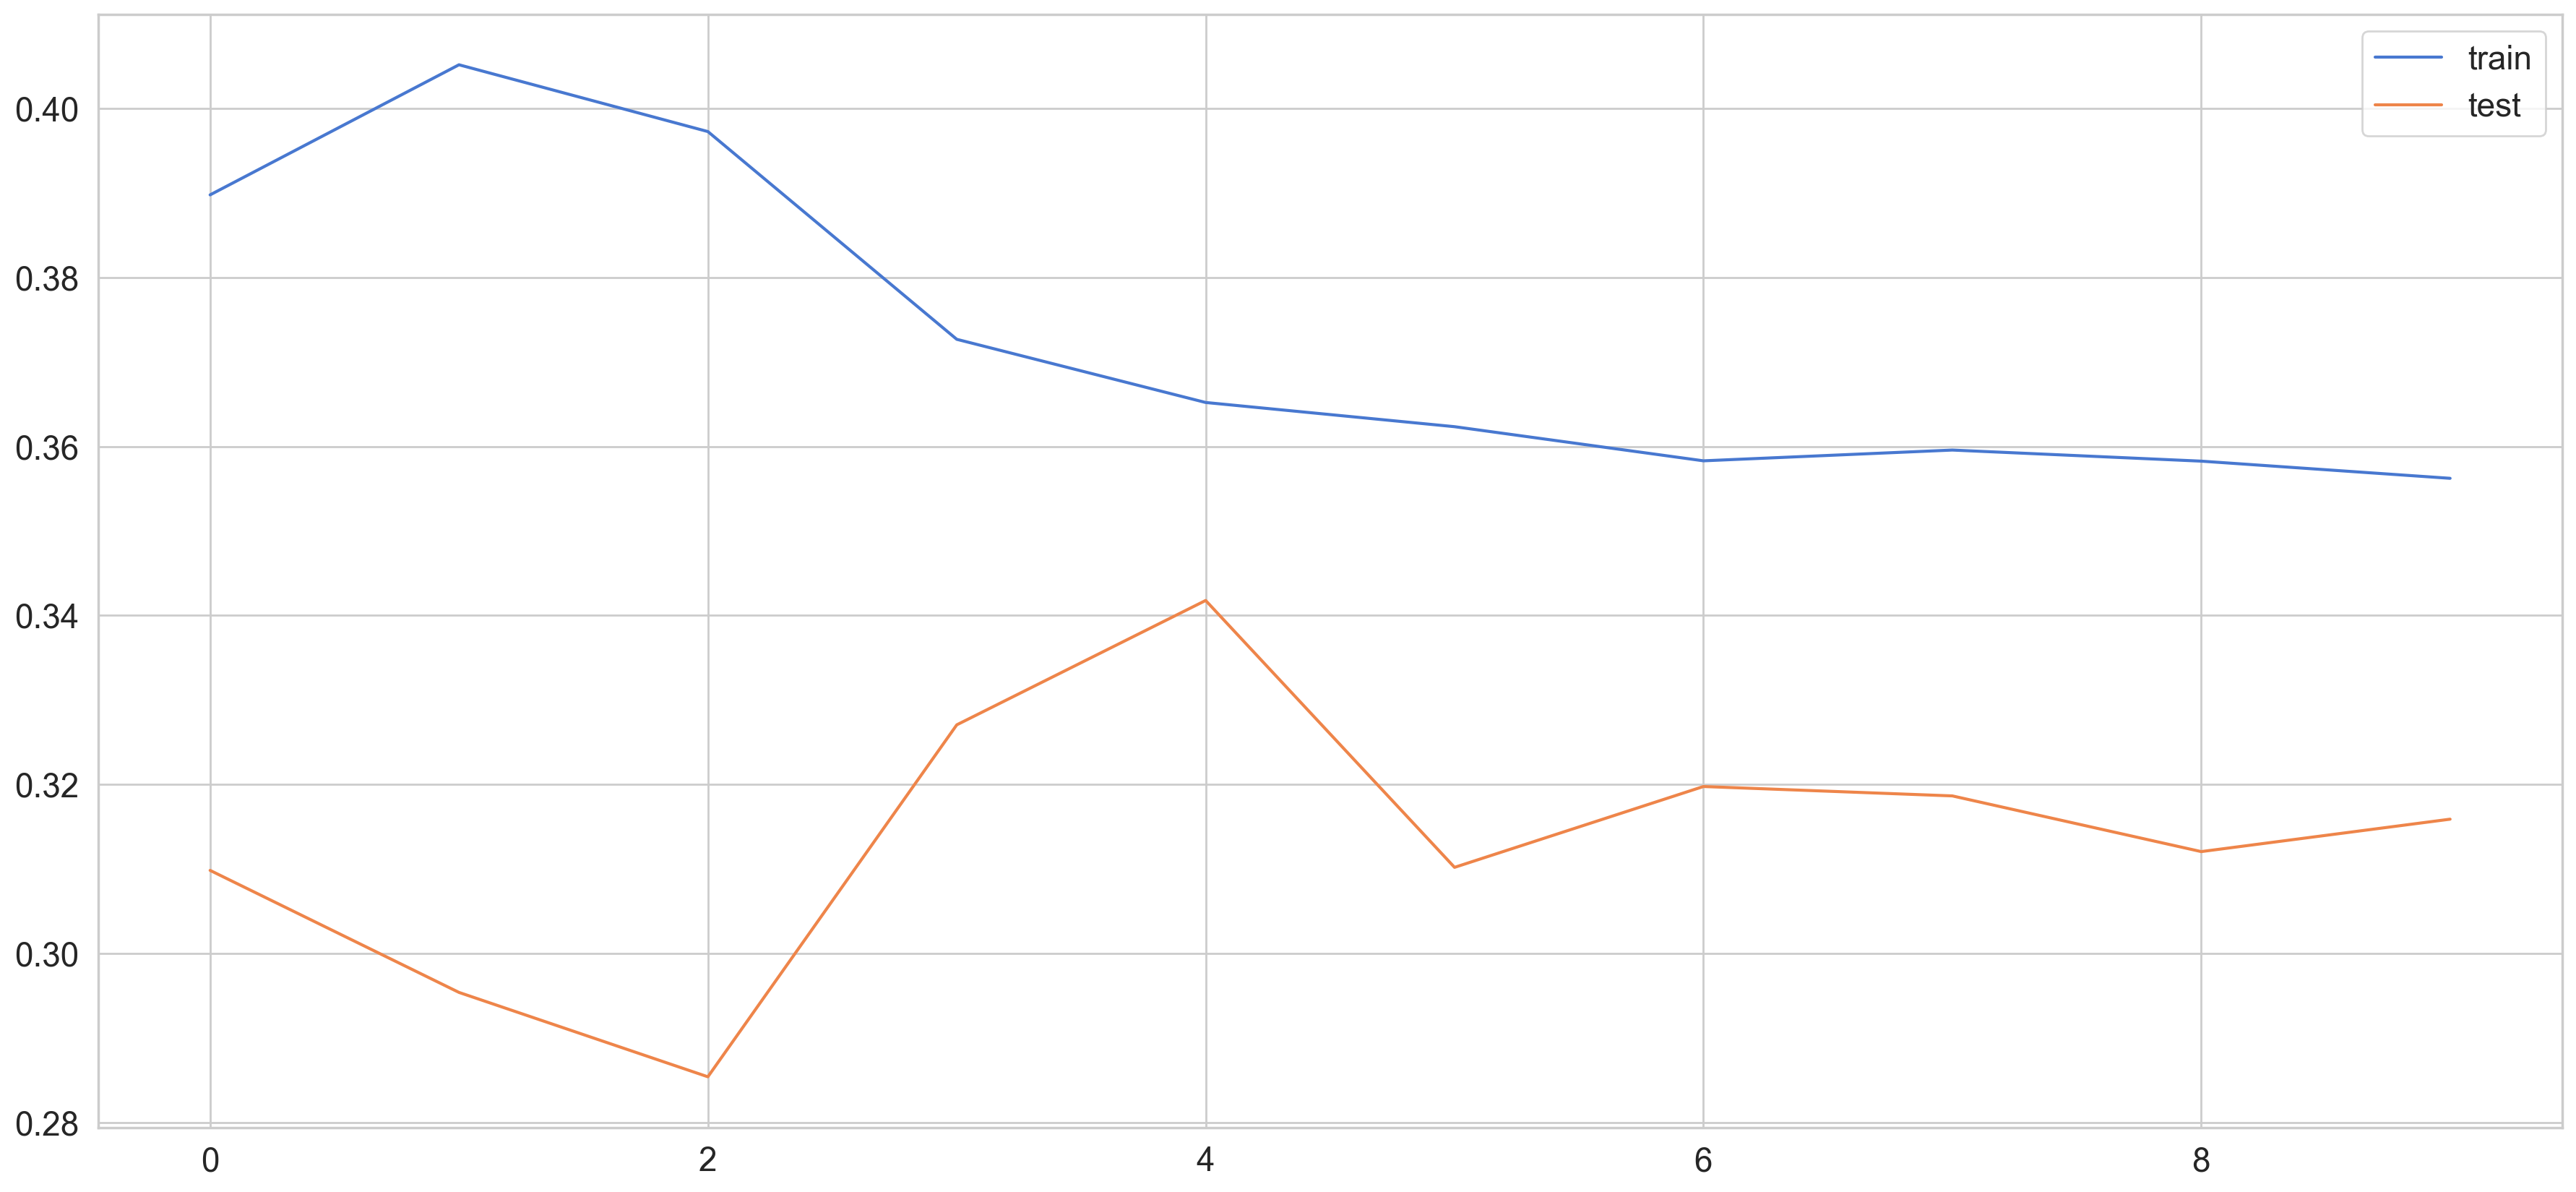

In [114]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend();

In [115]:
X_train_pred = model.predict(X_train)

train_mae_loss = np.mean(np.abs(X_train_pred - X_train), axis=1)

54/54 [==============================] - 2s 17ms/step


In [128]:
train_mae_loss[train_mae_loss>1.5]

array([1.51980903, 1.76163295, 2.06788608, 2.3766915 , 2.67551153,
       2.91117992, 2.96877259, 3.18968187, 3.23107032, 3.20905514,
       3.21450919, 3.21473805, 3.21534813, 3.21575254, 3.21600084,
       3.21568037, 3.21301232, 3.21008901, 3.20579088, 3.20601916,
       3.20893863, 3.21073353, 3.13945747, 3.13076129, 3.12143731,
       3.11346082, 3.08814255, 2.78038913, 2.47334235, 2.16872597,
       1.86831561, 1.56790974, 1.66768982, 1.75405512, 1.74974649,
       1.72233365, 1.69718634, 1.67567394, 1.66005929, 1.65265422,
       1.65161439, 1.65758869, 1.67390374, 1.7317518 , 1.8040656 ,
       1.91432128, 1.9995866 , 2.06877803, 2.11542095, 2.14260333,
       2.14955918, 2.13623997, 2.10636746, 2.06425631, 2.0150038 ,
       1.95734329, 1.89159287, 1.81456925, 1.7755617 , 1.71505216,
       1.69392008, 1.54522635])

C:\Users\ash\AppData\Local\Temp\ipykernel_5136\1731640021.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(train_mae_loss, bins=50, kde=True);


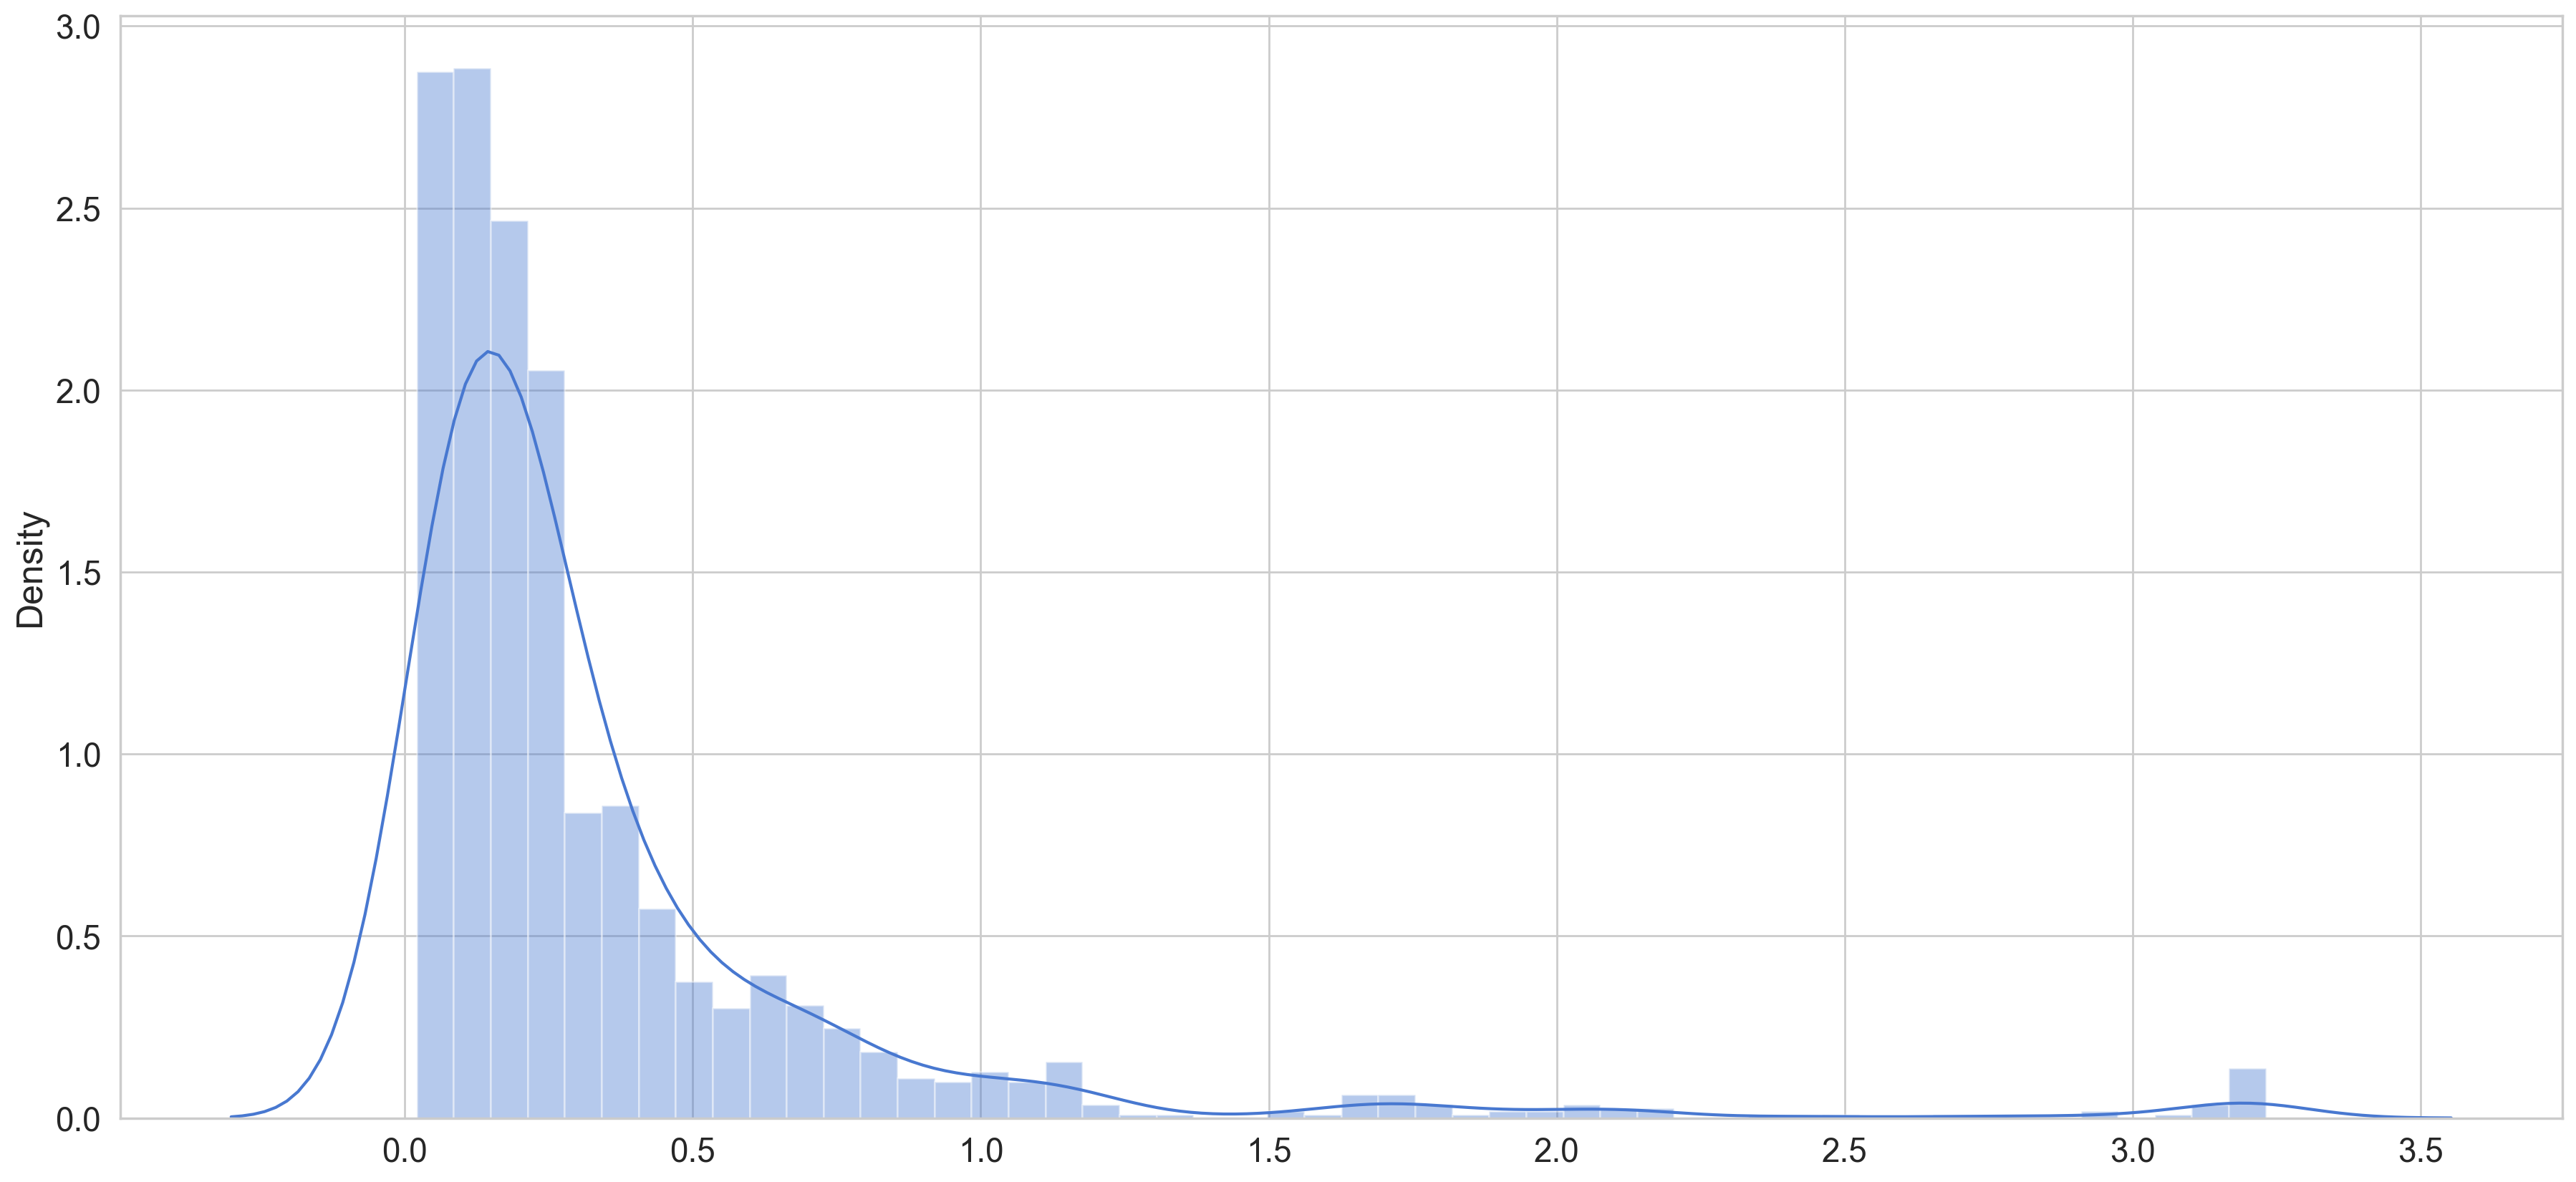

In [116]:
sns.distplot(train_mae_loss, bins=50, kde=True);

In [117]:
X_test_pred = model.predict(X_test)

test_mae_loss = np.mean(np.abs(X_test_pred - X_test), axis=1)

2/2 [==============================] - 0s 15ms/step


In [133]:
test

,AVG_DOWNHOLE_PRESSURE
DATEPRD,
2014-12-22,0.594751
2014-12-23,0.594748
2014-12-24,0.595947
2014-12-25,0.597184
2014-12-26,0.599177
...,...
2015-03-19,0.729254
2015-03-20,0.728339
2015-03-21,0.727335


,AVG_DOWNHOLE_PRESSURE
DATEPRD,
2014-12-22,3796.043151
2014-12-23,3796.041926
2014-12-24,3796.496450
2014-12-25,3796.965137
2014-12-26,3797.720342
...,...
2015-03-19,3847.013385
2015-03-20,3846.666639
2015-03-21,3846.286199


In [134]:
TIME_STEPS

30

In [147]:
THRESHOLD = 1.5

test_score_df = pd.DataFrame(index=df[-test.shape[0] + TIME_STEPS:].index)
test_score_df['AVG_DOWNHOLE_PRESSURE'] = df[-test.shape[0] + TIME_STEPS:]
test_score_df['loss'] = test_mae_loss
test_score_df['threshold'] = THRESHOLD
test_score_df['anomaly'] = test_score_df.loss > test_score_df.threshold


In [148]:
test_score_df

,AVG_DOWNHOLE_PRESSURE,loss,threshold,anomaly
DATEPRD,,,,
2015-01-21,3816.582522,0.244502,1.5,False
2015-01-22,3812.729419,0.251914,1.5,False
2015-01-23,3812.602640,0.257993,1.5,False
2015-01-24,3811.467772,0.263116,1.5,False
2015-01-25,3810.222626,0.267595,1.5,False
...,...,...,...,...
2015-03-19,3847.013385,0.291939,1.5,False
2015-03-20,3846.666639,0.292528,1.5,False
2015-03-21,3846.286199,0.293121,1.5,False


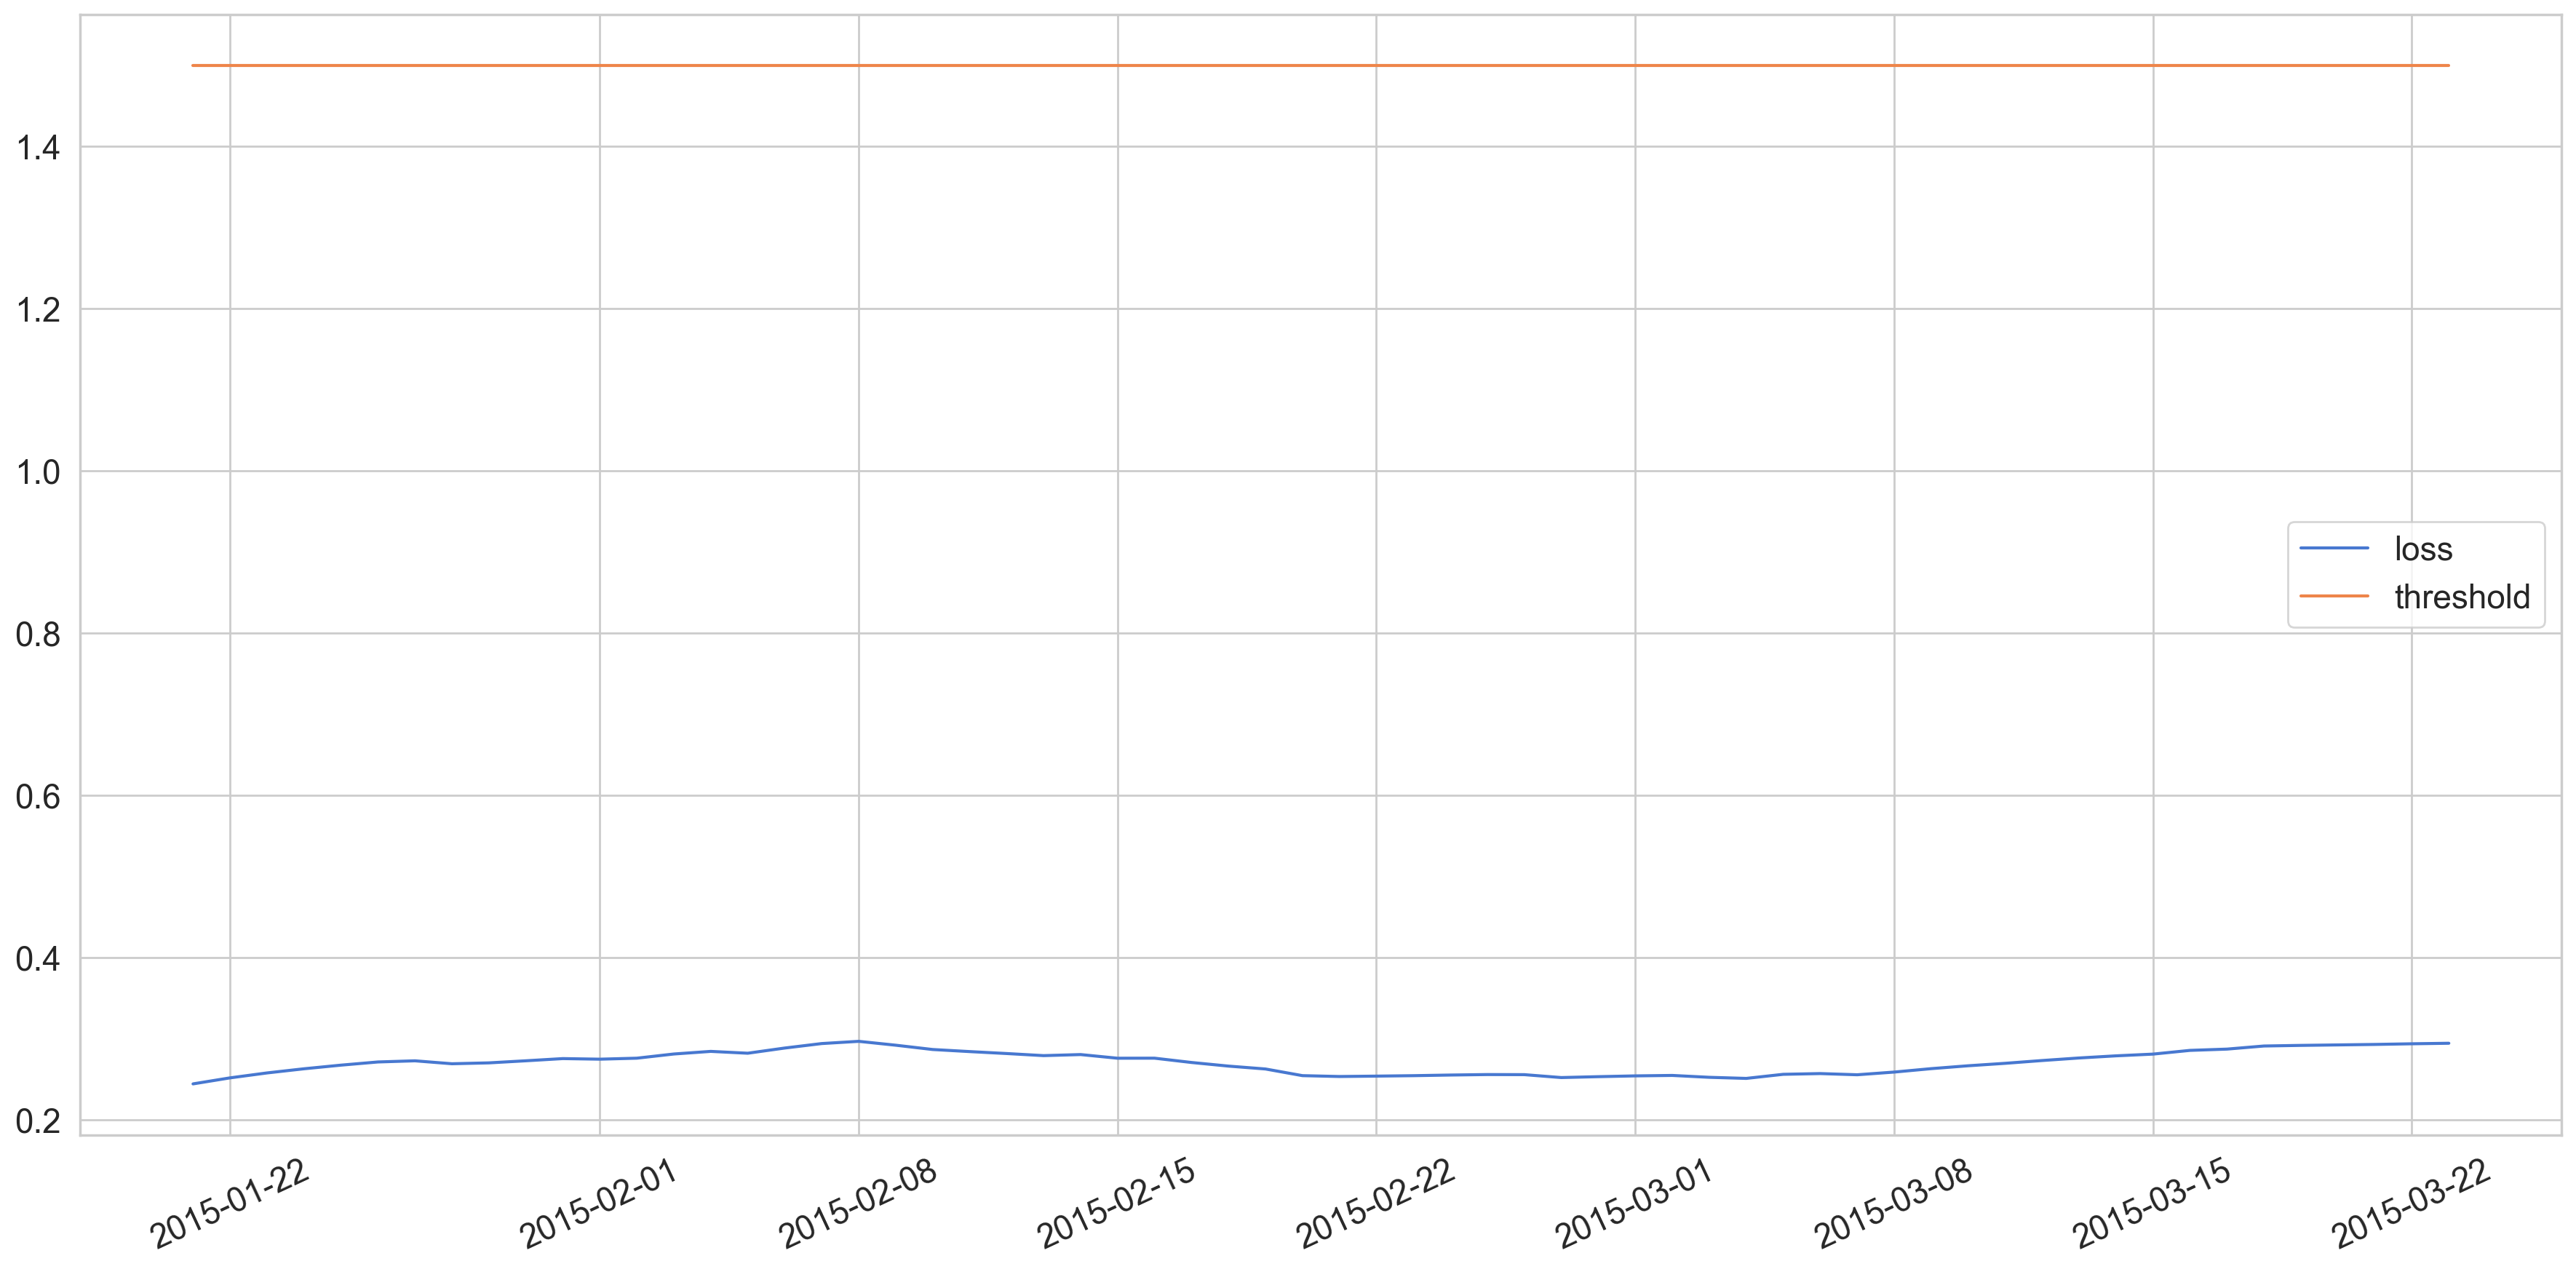

In [149]:
plt.plot(test_score_df.index, test_score_df.loss, label='loss')
plt.plot(test_score_df.index, test_score_df.threshold, label='threshold')
plt.xticks(rotation=25)
plt.legend();

In [150]:
anomalies = test_score_df[test_score_df.anomaly == True]
anomalies.head()

,AVG_DOWNHOLE_PRESSURE,loss,threshold,anomaly
DATEPRD,,,,


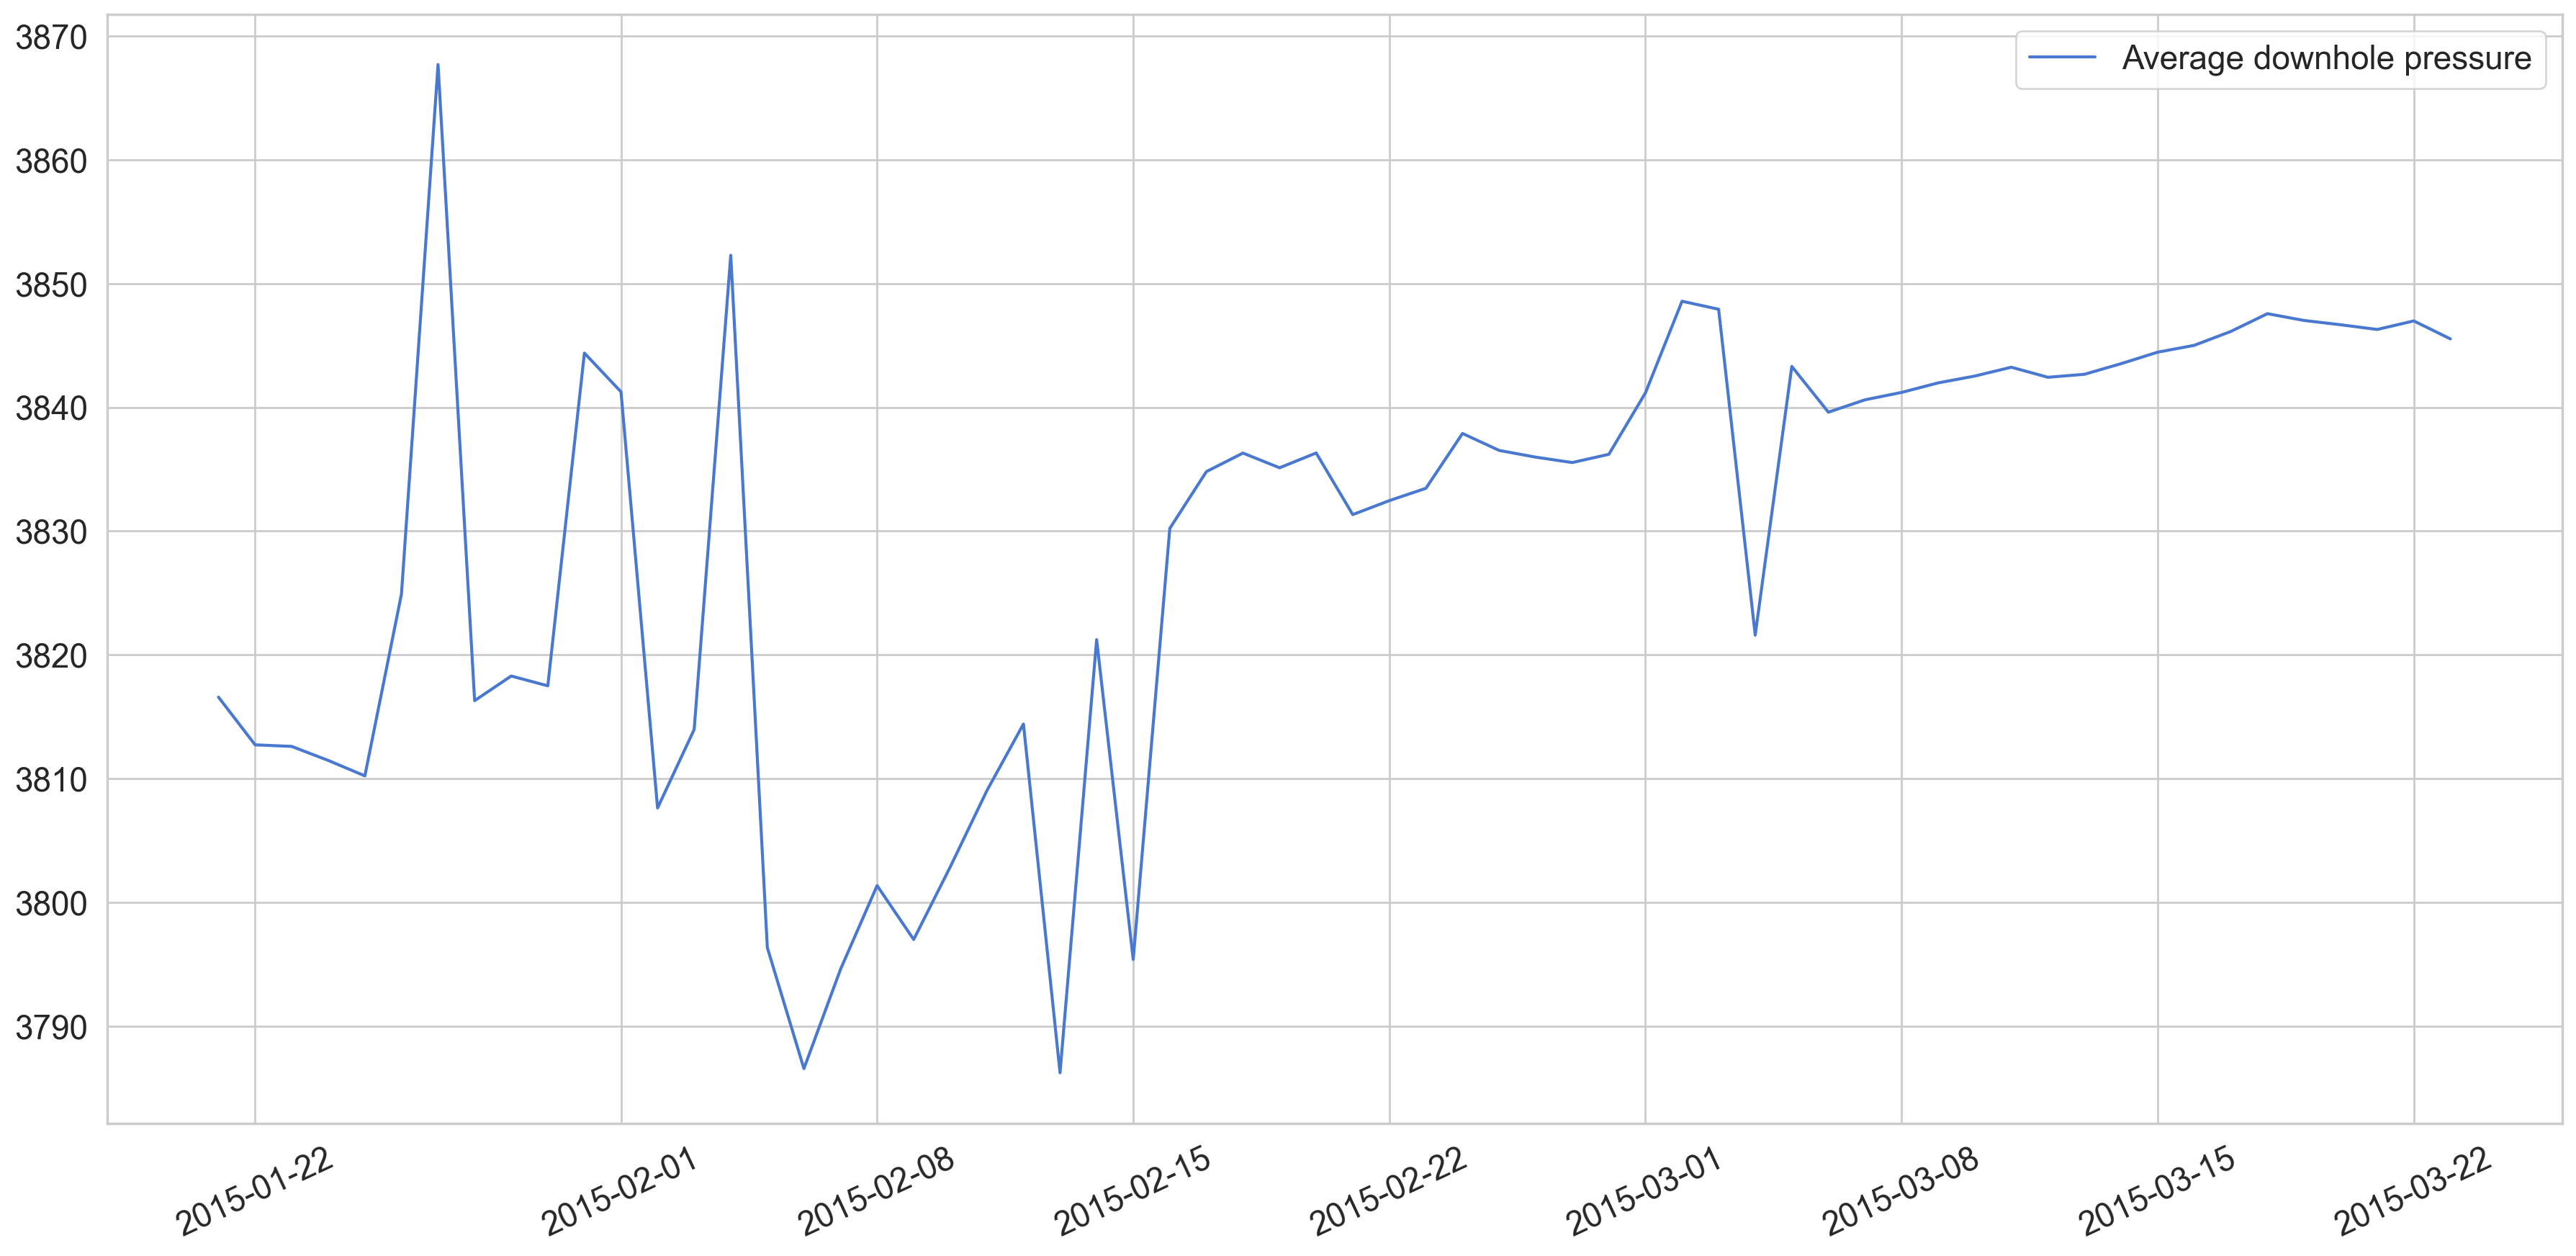

In [157]:
plt.plot(
  test[TIME_STEPS:].index, 
  scaler.inverse_transform(test[TIME_STEPS:].AVG_DOWNHOLE_PRESSURE.values.reshape(-1,1)), 
  label='Average downhole pressure'
);

if len(anomalies) > 0:
  sns.scatterplot(
    x=anomalies.index,
    y=scaler.inverse_transform(anomalies.AVG_DOWNHOLE_PRESSURE.values.reshape(-1,1)),
    color=sns.color_palette()[3],
    s=52,
    label='anomaly'
  )

plt.xticks(rotation=25)
plt.legend();